# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [35]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, udf, concat, col, desc, year, month, asc, count, avg, countDistinct
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from functools import reduce

In [36]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [37]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [38]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
names = df.schema.names
print('There are {} features'.format(len(names)))

There are 18 features


In [40]:
df.createOrReplaceTempView("df_view")

In [41]:
df.select(names).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [42]:
df.select(names[:9]).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|
|        Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|
|              Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|
|           Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|
|The All-American ...|Logged In|    Micah|     M|           81|    Long|208.29995| free|Boston-Cambridge-...|
|The Velve

In [43]:
df.select(names[9:]).show()

+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|   PUT|       NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|   PUT|       NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|   PUT|       NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|   PUT|       NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
|   PUT|       NextSong|1538331630000|        8|

In [44]:
spark.sql("SELECT DISTINCT level FROM df_view").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [45]:
spark.sql("SELECT page, COUNT(*) AS num FROM df_view GROUP BY page ORDER BY num DESC").show(10)

+---------------+------+
|           page|   num|
+---------------+------+
|       NextSong|228108|
|           Home| 14457|
|      Thumbs Up| 12551|
|Add to Playlist|  6526|
|     Add Friend|  4277|
|    Roll Advert|  3933|
|          Login|  3241|
|         Logout|  3226|
|    Thumbs Down|  2546|
|      Downgrade|  2055|
+---------------+------+
only showing top 10 rows



In [46]:
spark.sql("SELECT DISTINCT userID , COUNT(*) AS num FROM df_view GROUP BY userID ORDER BY userID ASC").show()

+------+----+
|userID| num|
+------+----+
|      |8346|
|    10| 795|
|   100|3214|
|100001| 187|
|100002| 218|
|100003|  78|
|100004|1245|
|100005| 216|
|100006|  44|
|100007| 520|
|100008| 940|
|100009| 671|
|100010| 381|
|100011|  23|
|100012| 600|
|100013|1392|
|100014| 310|
|100015|1050|
|100016| 638|
|100017|  75|
+------+----+
only showing top 20 rows



In [47]:
spark.sql("SELECT DISTINCT sessionID, COUNT(*) AS num FROM df_view GROUP BY sessionID ORDER BY sessionID ASC").show()

+---------+---+
|sessionID|num|
+---------+---+
|        1|714|
|        2|  7|
|        3| 38|
|        4| 24|
|        5| 58|
|        6| 71|
|        7|  1|
|        8| 49|
|        9|197|
|       10|176|
|       11| 47|
|       12| 60|
|       13|122|
|       15|220|
|       16| 39|
|       17|171|
|       18| 30|
|       19|158|
|       20| 29|
|       21|138|
+---------+---+
only showing top 20 rows



# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

#### 统计个数

In [48]:
df.count()

286500

#### 清除userId和sessionId喂na的数据

In [49]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

#### 清除userid为空的数据

In [50]:
df = df.filter(df.userId!="")
df.count()

278154

In [51]:
#定义churn 函数，分析Cancellation Confirmation
def processChurn(data):
    '''
    增加churn属性
    '''
    data.createOrReplaceTempView('user_log_table')

    # data with churned users
    churned_users = spark.sql('SELECT DISTINCT userId, 1 as churn FROM user_log_table WHERE Page = "Cancellation Confirmation"')
    # data with non churned users
    non_churned_users = spark.sql('SELECT DISTINCT userId, 0 as churn FROM user_log_table \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM user_log_table WHERE Page = "Cancellation Confirmation")')

    # Creating a combined dataset of churned users and non churned users
    combined_churn = churned_users.union(non_churned_users)
    combined_churn.createOrReplaceTempView('churn_and_non_churn')
    combined_churn = spark.sql('SELECT * FROM churn_and_non_churn')
    return combined_churn

In [52]:
combined_churn = processChurn(df)
churn_data = df.join(combined_churn, on='userId')
df = churn_data

In [53]:
df.head()

Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', churn=0)

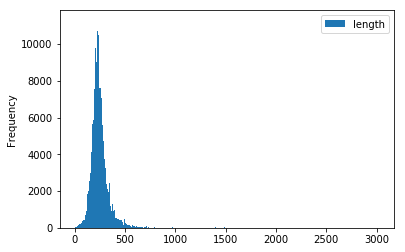

In [54]:
#length 可视化
data_len = df.select("length").toPandas()
data_len.plot(kind = "hist", bins = 500)

In [55]:
convert_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

Text(0.5,0.98,'Churned user by subscription-level')

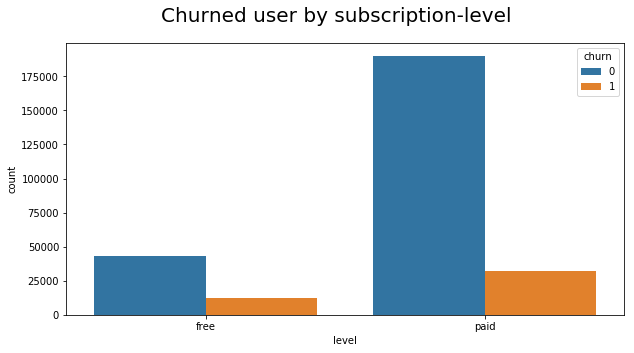

In [56]:
#付费状况的展示
plt.figure(figsize=(10,5))
data_level=df.groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='level', y='count', hue='churn', data=data_level)
plt.suptitle('Churned user by subscription-level', fontsize=20)

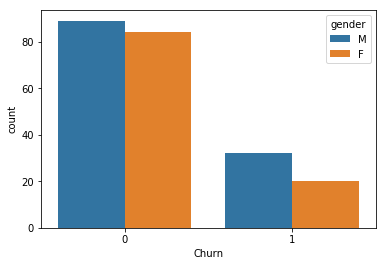

In [57]:
#churn状态的展示
df_pd = df.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='gender', data=df_pd)

In [58]:
#格式化时间
def convertDatetime(data):
    '''
    格式化registration_date的时间
    '''
    # Convert registration date
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
    data = data.withColumn("registration_date", get_date(data.registration))
    # Convert hour
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))
    data = data.withColumn("hour", get_hour(data.ts))
    
    return data
df = convertDatetime(df)

In [59]:
df.select('registration_date').distinct().show(5)

+-----------------+
|registration_date|
+-----------------+
|       2018-08-23|
|       2018-06-22|
|       2018-08-24|
|       2018-09-27|
|       2018-11-26|
+-----------------+
only showing top 5 rows



In [60]:
# 按照song 和arties排序
df.dropna().groupBy(['song', 'artist']).count().sort(desc('count')).show(5)
df.dropna().groupBy(['artist']).count().sort(desc('count')).show(5)

+--------------------+--------------------+-----+
|                song|              artist|count|
+--------------------+--------------------+-----+
|      You're The One|       Dwight Yoakam| 1122|
|                Undo|            BjÃÂ¶rk| 1026|
|             Revelry|       Kings Of Leon|  854|
|       Sehr kosmisch|            Harmonia|  728|
|Horn Concerto No....|Barry Tuckwell/Ac...|  641|
+--------------------+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
+--------------------+-----+
only showing top 5 rows



In [61]:
df_churn_user = df.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

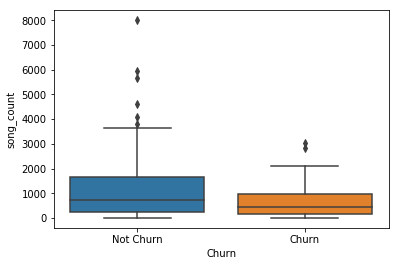

In [62]:
pd_song = df_churn_user.join(df.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="song_count", data=pd_song);

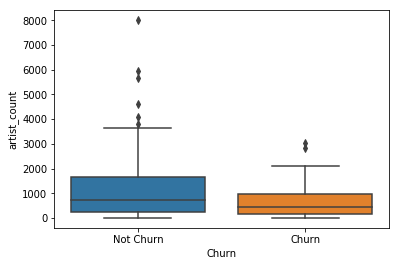

In [63]:
pd_artist = df_churn_user.join(df.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="artist_count", data=pd_artist);

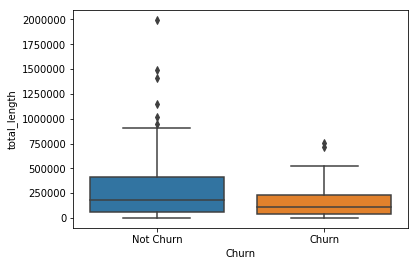

In [64]:
pd_length = df_churn_user.join(df.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="total_length", data=pd_length);

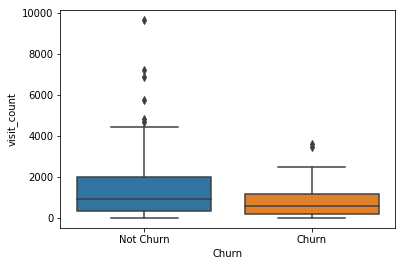

In [65]:
pd_visit = df_churn_user.join(df.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="visit_count", data=pd_visit);

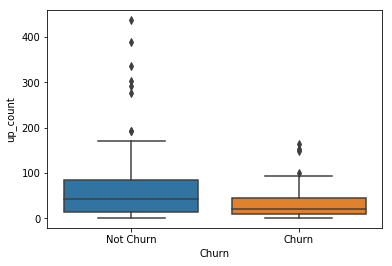

In [66]:
pd_up = df_churn_user.join(df.filter((df["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="up_count", data=pd_up);

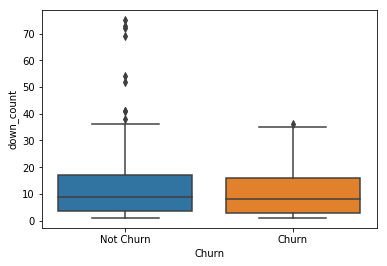

In [67]:
pd_down = df_churn_user.join(df.filter((df["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("Churn", convert_churn_label("Churn")).toPandas()
sns.boxplot(x="Churn", y="down_count", data=pd_down);

Text(0.5,0.98,'Churned user by location')

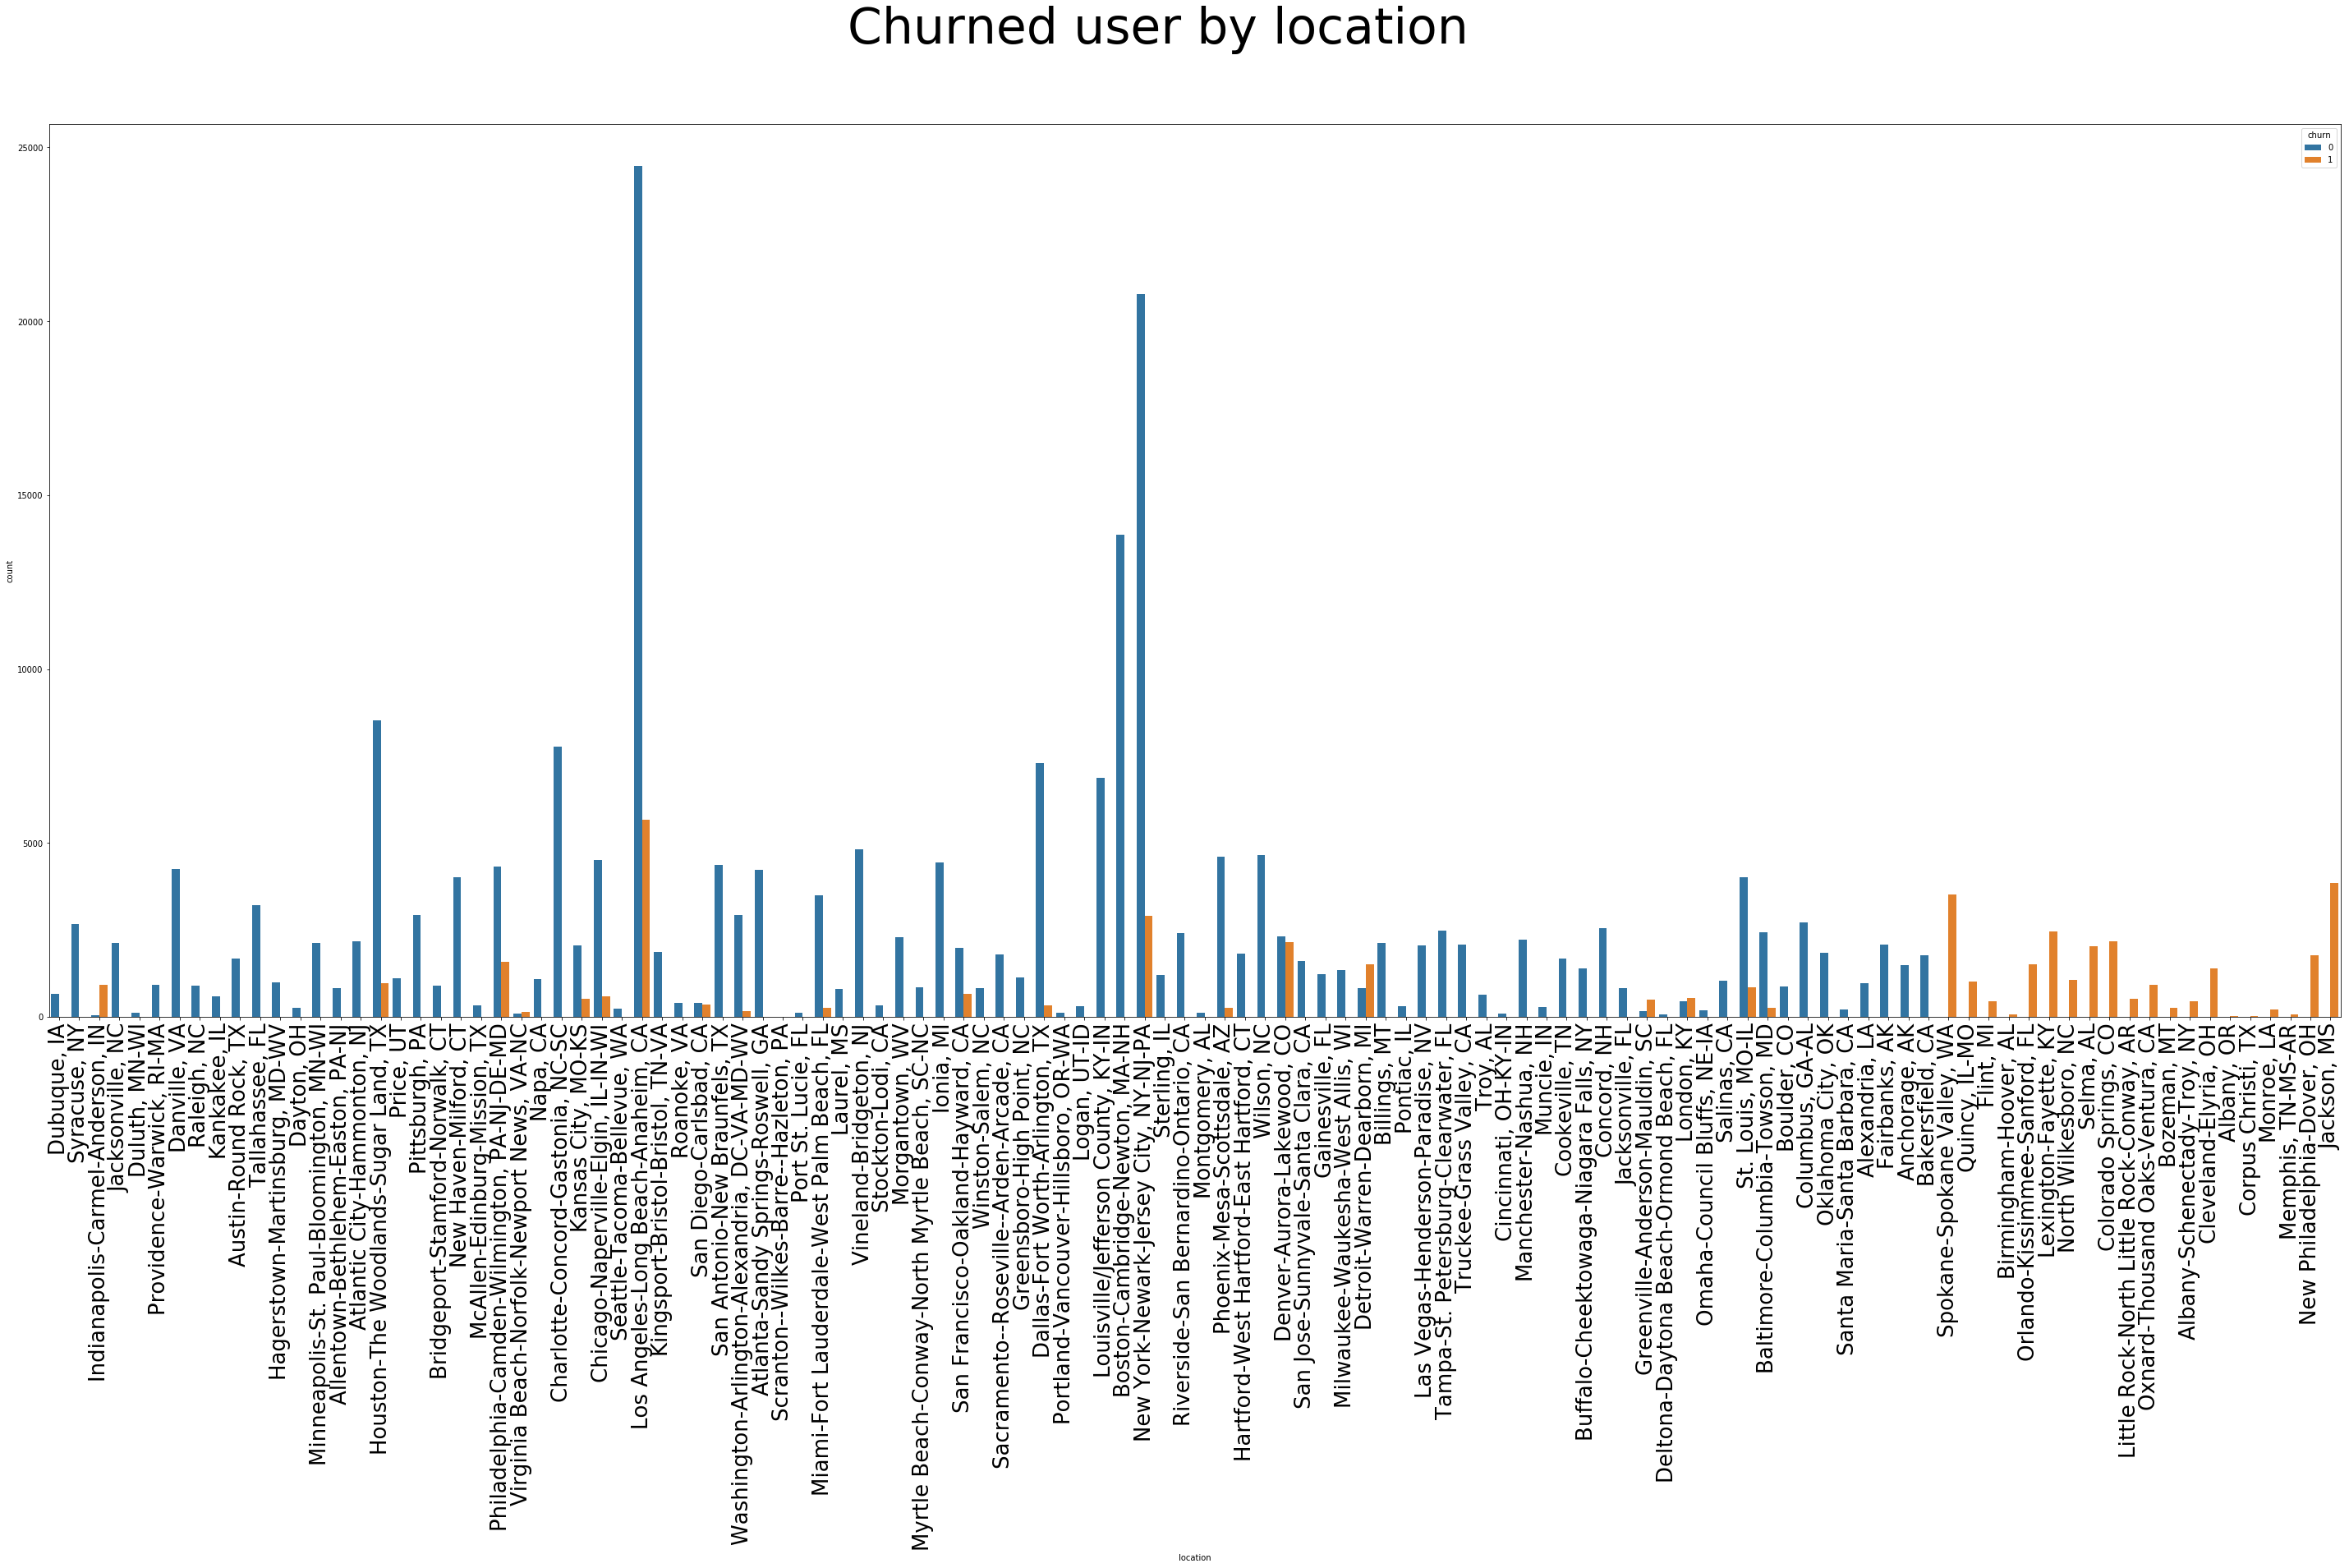

In [68]:
# Plot churned user by level and location
plt.figure(figsize=(50,20))
data_location=df.groupby(["location", "churn"]).count().sort("churn").toPandas()
data_location=sns.barplot(x='location', y='count', hue='churn', data=data_location);
plt.xticks(rotation=90, fontsize=26)
plt.suptitle('Churned user by location', fontsize=60)

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [69]:
def processFeatures(data):
    '''
    处理Gender, Thumps up, Thumps down, Listening time,Number of songs per user, free or paid user等特征
    最终将处理之后的特征整合之后返回
    '''
    # Gender category进行转化
    gender_num = data \
           .select('userId','gender')\
           .dropDuplicates() \
           .replace(['M','F'],['0','1'],'gender')\
           .select('userId',col('gender').cast('int'))\
           .withColumnRenamed('gender', 'gender_num') 
    
    # 统计Thumbs up
    thumbs_up = data \
             .select('userID','page') \
             .where(data.page == 'Thumbs Up') \
             .groupBy('userID') \
             .count() \
             .withColumnRenamed('count', 'thumbs_up') 
    
    # 统计Thumps down
    thumbs_down = data \
                 .select('userID','page') \
                 .where(data.page == 'Thumbs Down') \
                 .groupBy('userID') \
                 .count() \
                 .withColumnRenamed('count', 'thumbs_down')
    
    # 统计Listening Time的总和
    listening_time = data \
            .select('userId','length') \
            .groupby(['userId']) \
            .sum() \
            .withColumnRenamed('sum(length)','listening_time')

    # 计算每位user的song的数量
    song_per_user = data \
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","song_per_user")
    
    # 将Free or paid category特征进行转换
    level_num = data \
         .select('userId','level')\
         .replace(['free','paid'],['0','1'],'level')\
         .select('userId',col('level').cast('int'))\
         .withColumnRenamed('level', 'level_num') 
    
    # 提取churn并命名为label，在后续的训练的时候需要lable，此处进行命名
    churn = data \
        .select('userId', col('Churn').alias('label')) \
        .dropDuplicates()

    # 整合所有特征
    feature_data = song_per_user.join(gender_num,'userID','outer') \
              .join(thumbs_up,'userID','outer') \
              .join(thumbs_down, 'userID','outer') \
              .join(listening_time,'userID','outer') \
              .join(level_num,'userID','outer') \
              .join(churn,'userID','outer') \
              .drop('userID') \
              .fillna(0)


    
    return feature_data

In [70]:
df = processFeatures(df)

In [71]:
df.show(1)

+-------------+----------+---------+-----------+-----------------+---------+-----+
|song_per_user|gender_num|thumbs_up|thumbs_down|   listening_time|level_num|label|
+-------------+----------+---------+-----------+-----------------+---------+-----+
|          381|         1|       17|          5|66940.89735000003|        0|    0|
+-------------+----------+---------+-----------+-----------------+---------+-----+
only showing top 1 row



In [72]:
def transformAndScale(data):
    '''
    对特征进行scale操作，使用StandardScaler进行处理
    '''
    # Transform 操作
    cols = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time']
    assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
    dataAssemblered = assembler.transform(data)
    
    # Scale 操作
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
    scalerModel = scaler.fit(dataAssemblered)
    data = scalerModel.transform(dataAssemblered)
    
    return data

In [73]:
df= transformAndScale(df)

In [74]:
df.show(1)

+-------------+----------+---------+-----------+-----------------+---------+-----+--------------------+--------------------+
|song_per_user|gender_num|thumbs_up|thumbs_down|   listening_time|level_num|label|         NumFeatures|            features|
+-------------+----------+---------+-----------+-----------------+---------+-----+--------------------+--------------------+
|          381|         1|       17|          5|66940.89735000003|        0|    0|[381.0,1.0,17.0,5...|[0.18187483384873...|
+-------------+----------+---------+-----------+-----------------+---------+-----+--------------------+--------------------+
only showing top 1 row



# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [75]:
# 创建训练和测试数据
train, validation = df.randomSplit([0.8, 0.2], seed=42)

In [76]:
def trainAndValidateWithGivenModel(model,train=train,validation=validation):
    #统计处理时间
    start_time = time.time()
    ##使用f1 score指标
    f_score = MulticlassClassificationEvaluator(metricName='f1')
    model_train = model.fit(train)
    model_test = model_train.transform(validation)
    #结果评估
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    print("--------------------Start--------------------\n")
    print("Model Name is:", model)
    print("Accuracy is:")
    print(evaluator.evaluate(model_test,{evaluator.metricName: 'accuracy'}))
    print("F-1 score is :")
    print(evaluator.evaluate(model_test, {evaluator.metricName: 'f1'}))
    print("Running %s seconds \n" % (time.time() - start_time))
    print("---------------------End-------------------\n")
    return model

In [77]:
logist = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0)
gbt=GBTClassifier()
forest = RandomForestClassifier()
model = [gbt,logist,forest]
for i in model:
    trainAndValidateWithGivenModel(i,train,validation)

--------------------Start--------------------

Model Name is: GBTClassifier_2728bb659038
Accuracy is:
0.9898815310935868
F-1 score is :
0.9897499951607381
Running 609.903459072113 seconds 

---------------------End-------------------

--------------------Start--------------------

Model Name is: LogisticRegression_af08f61d6eca
Accuracy is:
0.8368801987684995
F-1 score is :
0.7625630322111933
Running 190.6146936416626 seconds 

---------------------End-------------------

--------------------Start--------------------

Model Name is: RandomForestClassifier_66421f2b6adf
Accuracy is:
0.8818011594829138
F-1 score is :
0.8521219246862239
Running 256.87881445884705 seconds 

---------------------End-------------------



结果分析，F1 score:
GBTClassifier：0.8044951325485031
LogisticRegression:0.7964339801776644
RandomForestClassifier:0.7964339801776644
从结果分析GBTClassifier有点过拟合，进一步对超参进行调节。准确率基本上一致。

进一步通过CrossValidator对GBTClassifier进行调参。

In [ ]:

def trainAndCrossValida(model=gbt,train=train,validation=validation):
    #统计处理时间
    start_time = time.time()
    f1_score = MulticlassClassificationEvaluator(metricName='f1')
    param_gbt = ParamGridBuilder()\
       .addGrid(gbt.maxIter,[5,10])\
       .addGrid(gbt.maxDepth,[5,10]) \
       .build()
    crossval_model = CrossValidator(estimator=model,
                           evaluator=f1_score,
                           estimatorParamMaps=param_gbt,
                           numFolds=3)
    model_train = crossval_model.fit(train)
    model_test = model_train.transform(validation)
    #结果评估
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    print("----------------------------------------\n")
    print("Model is:", model)
    print("Accuracy:")
    print(evaluator.evaluate(model_test,{evaluator.metricName: 'accuracy'}))
    print("F-1 score:")
    print(evaluator.evaluate(model_test, {evaluator.metricName: 'f1'}))
    print("Running %s seconds \n" % (time.time() - start_time))
    print("----------------------------------------\n")
    return model

In [79]:
trainAndCrossValida(gbt,train,validation)

----------------------------------------

Model is: GBTClassifier_2728bb659038
Accuracy:
0.99641712577869
F-1 score:
0.9964010597229603
Running 3677.6525661945343 seconds 

----------------------------------------



GBTClassifier_2728bb659038

CrossValidator使用3次折叠，将生成3个（训练，测试）数据集对，每个对都使用2/3的数据进行训练，并使用1/3的数据进行测试.当数据集比较小的时候交叉验证可以“充分利用”有限的数据找到合适的模型参数，防止过度拟合.
很明显当数据集较大的时候，导致整个训练的过程特别的漫长。

### 待改进：
- 在进行训练的时候应该使用pipeline进行处理，这样整体的逻辑和代码比较简单明了
- 通过CrossValidator进行处理，可以比较快速的得到较为优化的参数；
- 调参数在时候需要平衡精度和召回率，不能只针对精度进行优化；
- 尽可能将每一步的操作都概括为单个的函数；


### 难点：
- 由于对于模型的选择和参数设置没有很好的掌握，在数据集非常大的情况下每次运行话费的时间很长，导致花费的时间很久。


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。